# CSI4106 Assignment 2

## Group 24

|Name|Student No.|Email
|----|-----------|-----
|Hongyi Lin| 300053082| hlin087@uottawa.ca
|Rodger Retanal| 300052309| rreta014@uottawa.ca

In [3]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from pathlib import Path
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)


# load tensorboard extension
# %reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
# %tensorboard --logdir logs

#### Loading the relevant datasets (15/100)

train_set.shape = (15026, 4)
val_set.shape = (3757, 4)
test_set.shape = (4696, 4)
columns: Index(['age', 'ethnicity', 'gender', 'img_name'], dtype='object')

gender distribution in train_set:
 0    2456
1    2240
Name: gender, dtype: int64
gender distribution in val_set:
 0    1965
1    1792
Name: gender, dtype: int64
gender distribution in test_set:
 0    2456
1    2240
Name: gender, dtype: int64

ethnicity distribution in train_set:
 0    1991
1     896
3     790
2     683
4     336
Name: ethnicity, dtype: int64
ethnicity distribution in val_set:
 0    1593
1     717
3     632
2     547
4     268
Name: ethnicity, dtype: int64
ethnicity distribution in test_set:
 0    1991
1     896
3     790
2     683
4     336
Name: ethnicity, dtype: int64 


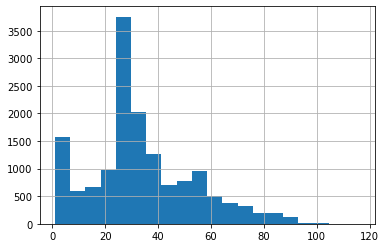

In [4]:
# load the datasets using the csv files train, val and test 
# (3)
train_set = pd.read_csv("./data/train.csv")
val_set = pd.read_csv("./data/val.csv")
test_set = pd.read_csv("./data/test.csv")

# print the shapes of the dataframes 
# (3)
print(f"train_set.shape = {train_set.shape}")
print(f"val_set.shape = {val_set.shape}")
print(f"test_set.shape = {test_set.shape}")

# print the column names from either one of the dataframes 
# (1)
print(f"columns: {train_set.columns}\n")

# print the proportional distribution of gender in all three datasets(i.e., number of male and female) 
# (3)
print(f"gender distribution in train_set:\n {test_set['gender'].value_counts()}")
print(f"gender distribution in val_set:\n {val_set['gender'].value_counts()}")
print(f"gender distribution in test_set:\n {test_set['gender'].value_counts()}\n")

# print the proportional distribution of ethnicity in all three datasets 
# (3)
print(f"ethnicity distribution in train_set:\n {test_set['ethnicity'].value_counts()}")
print(f"ethnicity distribution in val_set:\n {val_set['ethnicity'].value_counts()}")
print(f"ethnicity distribution in test_set:\n {test_set['ethnicity'].value_counts()} ")

# plot the age distribution from the training dataset where the x-axis plots the age
# and the y-axis depicts the count of individuals within each age group. For example, individuals with age=1 are:
# (2)
train_set["age"].hist(bins=20)
plt.show()

#### Create the ImageDataGenerators (22/100)

Found 15026 validated image filenames.
Found 3757 validated image filenames.
Found 4696 validated image filenames.
(16, 48, 48, 1)
(48, 48, 1)


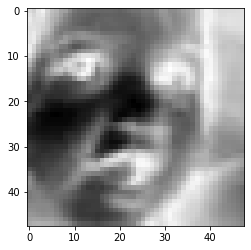

In [5]:
# ImageDataGenerator is an iterator.

# specify the batch size hyperparameter. You can experiment with different batch sizes
BATCH_SIZE = 16

# create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# use at least two of the augmentation strategies. For example, fill_mode='nearest'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (3)
train_img_gen = ImageDataGenerator(
    rescale= 1.0 / 255,
    fill_mode="constant",
    cval=0.0
)

# set up the x_col and y_col
x_col = "img_name"
y_col = list(train_set.columns)
y_col.remove(x_col)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)
train_itr = train_img_gen.flow_from_dataframe(
    dataframe=train_set,
    directory="./data/images/train/",
    x_col=x_col,
    y_col=y_col,
    batch_size=BATCH_SIZE,
    target_size=(48, 48),
    seed=SEED,
    color_mode="grayscale",
    class_mode="multi_output"
)


# similarly, create an ImageDataGenerator for the validation dataset and make sure not to use any of th eaugmentation strategies except rescaling the image
# (2)
val_img_gen = ImageDataGenerator(
    rescale= 1.0 / 255
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance with the same arguments as above
# make sure to specify the following arguments:
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
val_itr = val_img_gen.flow_from_dataframe(
    dataframe=val_set,
    directory="./data/images/val/",
    x_col=x_col,
    y_col=y_col,
    batch_size=BATCH_SIZE,
    target_size=(48, 48),
    seed=SEED,
    color_mode="grayscale",
    class_mode="multi_output",
    shuffle=False
)

# use the method "flow_from_dataframe" from the val_img_gen instance to link the test dataframe and the test data folder
# In addition, make sure to specify the following arguments
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
test_itr = val_img_gen.flow_from_dataframe(
    dataframe=test_set,
    directory="./data/images/test/",
    x_col=x_col,
    y_col=y_col,
    batch_size=BATCH_SIZE,
    target_size=(48, 48),
    seed=SEED,
    color_mode="grayscale",
    class_mode="multi_output",
    shuffle=False
)

# enumerate through the validation data generator created above and plot first grayscale image 
# (2)
for i, element in enumerate(val_itr):
    print(element[0].shape)
    tmp = element[0][0]
    print(tmp.shape)
    plt.imshow(tmp, cmap=plt.cm.binary)
    break

#### Create the model (44/100)

In [6]:
# specify the model input with the required shape 
# (1)
inputs = layers.Input(shape=(48, 48, 1))

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
# (10)
shared_layers = layers.Conv2D(
    filters=8,
    kernel_size=3,
    activation="relu",
    strides=(1, 1),
    dilation_rate=(1, 1),
    padding="same"
)(inputs)
shared_layers = layers.MaxPooling2D(
    pool_size=(2, 2)
)(shared_layers)
shared_layers = layers.Flatten()(shared_layers)

# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age
# (2)
task_layers_age = layers.Dense(units=128, activation="relu", name="age_dense_1")(shared_layers)

# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task
# (2)
AGE_OUT = "age_dense_out"
outputs_age = layers.Dense(units=1, activation="linear", name=AGE_OUT)(task_layers_age) # NOTE: regression units=1

# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction
# (2)
task_layers_ethnicity = layers.Dense(units=128, activation="relu", name="ethnicity_dense_1")(shared_layers)

# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task
# (2)
ETHNICITY_OUT = "ethnicity_dense_out"
outputs_ethnicity = layers.Dense(units=5, activation="softmax", name=ETHNICITY_OUT)(task_layers_ethnicity) # NOTE: multi-class classification, units=num of classes

# Similar to above, specify one or more Dense layers as task specific layers for gender prediction
# (2)
task_layers_gender = layers.Dense(units=128, activation="relu", name="gender_dense_1")(shared_layers) # NOTE: task layers unit can be more than 1

# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task
# (2)
GENDER_OUT = "gender_dense_out"
outputs_gender = layers.Dense(units=1, activation="sigmoid", name=GENDER_OUT)(task_layers_gender) # NOTE: sigmoid, units=1 only

# create the model with the required input and the outputs.
# please make sure that the outputs can be included in a list and make sure to keep note of the order
# (3)
outputs_list = [outputs_age, outputs_ethnicity, outputs_gender]
outputs_idx = {
    "age": 0,
    "ethnicity": 1,
    "gender": 2
}
model = tf.keras.Model(inputs=inputs, outputs=outputs_list, name="group_24_model")

# print the model summary
# (0.5)
print(model.summary())

# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# (2)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)
LOSSES = {
    AGE_OUT: "mae",
    ETHNICITY_OUT: "sparse_categorical_crossentropy",
    GENDER_OUT: "binary_crossentropy"
}

# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# loss_weights=[0.001, 0.5, 0.5]
# please remember to use the relevant metric for each task by assigning it to the correct output
# (2)
LOSS_WEIGHTS = {
    AGE_OUT: 0.001,
    ETHNICITY_OUT: 0.5,
    GENDER_OUT: 0.5
}
METRICS = {
    AGE_OUT: "mae",
    ETHNICITY_OUT: "accuracy",
    GENDER_OUT: "accuracy"
}
model.compile(optimizer=optimizer, loss=LOSSES, loss_weights=LOSS_WEIGHTS, metrics=METRICS)

# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# (2)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# create dirs for the checkpoint and tensorboard
def make_dirs():
    d = datetime.datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    Path(tensorlog_folder).mkdir(exist_ok=True, parents=True)
    Path(checkpoint_folder).mkdir(exist_ok=True, parents=True)

    return checkpoint_folder, tensorlog_folder

check_dir, tboard_dir = make_dirs()

# ModelCheckpoint
# monitor validation loss and save the best model weights
# (2)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False
)

# Initiallize TensorBoard
# (2)
tboard = tf.keras.callbacks.TensorBoard(
    log_dir = tboard_dir
)

# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# (2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    min_lr=5e-5,
    verbose=1
)

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)
print(f"len(train_itr)={len(train_itr)}")
print(f"GPU={tf.config.list_physical_devices('GPU')}")
print(f"is_built_with_cuda={tf.test.is_built_with_cuda()}")
print(type(train_itr))
model.fit(
    train_itr,
    validation_data=val_itr,
    steps_per_epoch=len(train_itr) / BATCH_SIZE,
    validation_steps=len(val_itr) / BATCH_SIZE,
    epochs=20,
    shuffle=True,
    callbacks=[reduce_lr, early_stop, checkpoint, tboard]
)

Model: "group_24_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 24, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 4608)         0           max_pooling2d[0][0]              
_____________________________________________________________________________________

#### Making predictions on test data (14/100)

In [7]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions
# (4)
test_evals = model.evaluate(test_itr, verbose=1)
print(f"\nTest evaluation:\n{test_evals}")

294/294 [==============================] - 1s 4ms/step - loss: 0.5771 - age_dense_out_loss: 10.8378 - ethnicity_dense_out_loss: 0.8108 - gender_dense_out_loss: 0.3217 - age_dense_out_mae: 10.8378 - ethnicity_dense_out_accuracy: 0.7206 - gender_dense_out_accuracy: 0.8588

Test evaluation:
[0.5770628452301025, 10.837848663330078, 0.8107830286026001, 0.32166674733161926, 10.837848663330078, 0.7206133008003235, 0.8588160276412964]


In [8]:
# generate predictions using the test generator
# (2)
predictions = model.predict(test_itr, verbose=1)
# print(f"\nPredictions:\n{predictions}")

# extract the ethnicity predictions
# (2)
# NOTE: we can only extract by remembering the order? 2nd is ethnicity
predictions_ethnicity = np.argmax(predictions[outputs_idx["ethnicity"]], axis=1)
# print(predictions_ethnicity)

# print the classification report for predicting ethnicity
# (2)
cr_ethnicity = classification_report(test_set["ethnicity"].values, predictions_ethnicity)
print(f"Ethnicity Classification Report:\n{cr_ethnicity}")

# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
# (2)
predictions_gender = predictions[outputs_idx["gender"]].flatten().tolist()
for i in range(0, len(predictions_gender)):
    predictions_gender[i] = 1 if predictions_gender[i] > 0.5 else 0
# print(predictions_gender)

# print the classification report for predicting gender
# (2)
cr_gender = classification_report(test_set["gender"].values, predictions_gender)
print(f"Gender Classification Report:\n{cr_gender}")

294/294 [==============================] - 1s 4ms/step
Ethnicity Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1991
           1       0.75      0.78      0.76       896
           2       0.72      0.73      0.72       683
           3       0.65      0.66      0.65       790
           4       0.43      0.04      0.07       336

    accuracy                           0.72      4696
   macro avg       0.66      0.61      0.60      4696
weighted avg       0.70      0.72      0.70      4696

Gender Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      2456
           1       0.84      0.87      0.85      2240

    accuracy                           0.86      4696
   macro avg       0.86      0.86      0.86      4696
weighted avg       0.86      0.86      0.86      4696



#### Present prediction results on test data(5/100)

In [9]:
from tensorboard.plugins.hparams import api as hp

HP_BATCH_SIZE = hp.HParam("batch_size", hp.Discrete([8, 16]))
HP_OPTIMIZER = hp.HParam("optimizer", hp.Discrete(["RMSprop", "Adam", "Adamax"]))
HP_FILTERS = hp.HParam("units", hp.Discrete([8, 16, 32]))
HP_UNITS = hp.HParam("units", hp.Discrete([64, 128, 256]))

In [10]:
def get_df_itr(bactch_size: int):
    train_itr = train_img_gen.flow_from_dataframe(
        dataframe=train_set,
        directory="./data/images/train/",
        x_col=x_col,
        y_col=y_col,
        batch_size=bactch_size,
        target_size=(48, 48),
        seed=SEED,
        color_mode="grayscale",
        class_mode="multi_output"
    )
    val_itr = val_img_gen.flow_from_dataframe(
        dataframe=val_set,
        directory="./data/images/val/",
        x_col=x_col,
        y_col=y_col,
        batch_size=bactch_size,
        target_size=(48, 48),
        seed=SEED,
        color_mode="grayscale",
        class_mode="multi_output",
        shuffle=False
    )
    test_itr = val_img_gen.flow_from_dataframe(
        dataframe=test_set,
        directory="./data/images/test/",
        x_col=x_col,
        y_col=y_col,
        batch_size=bactch_size,
        target_size=(48, 48),
        seed=SEED,
        color_mode="grayscale",
        class_mode="multi_output",
        shuffle=False
    )
    return {"train": train_itr, "val": val_itr, "test": test_itr}

In [11]:
def create_model(filters, units, id):
    # input
    inputs = layers.Input(shape=(48, 48, 1))

    # shared layers
    shared_layers = layers.Conv2D(
        filters=filters,
        kernel_size=3,
        activation="relu",
        strides=(1, 1),
        dilation_rate=(1, 1),
        padding="same"
    )(inputs)
    shared_layers = layers.MaxPooling2D(
        pool_size=(2, 2)
    )(shared_layers)
    shared_layers = layers.Flatten()(shared_layers)

    # task specific layers
    task_layers_age = layers.Dense(units=units, activation="relu", name="age_dense_1")(shared_layers)
    outputs_age = layers.Dense(units=1, activation="linear", name=AGE_OUT)(task_layers_age)

    task_layers_ethnicity = layers.Dense(units=units, activation="relu", name="ethnicity_dense_1")(shared_layers)
    outputs_ethnicity = layers.Dense(units=5, activation="softmax", name=ETHNICITY_OUT)(task_layers_ethnicity)
    
    task_layers_gender = layers.Dense(units=units, activation="relu", name="gender_dense_1")(shared_layers)
    outputs_gender = layers.Dense(units=1, activation="sigmoid", name=GENDER_OUT)(task_layers_gender)

    # create the model
    outputs_list = [outputs_age, outputs_ethnicity, outputs_gender]
    model = tf.keras.Model(inputs=inputs, outputs=outputs_list, name="group_24_model_" + str(id))
    return model

def make_session_dirs(parent_dir, session):
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(parent_dir, "logs", str(session))
    # folder to store the trained models
    checkpoint_folder = os.path.join(parent_dir, "models", str(session))

    Path(checkpoint_folder).mkdir(parents=True, exist_ok=True)
    Path(tensorlog_folder).mkdir(parents=True, exist_ok=True)

    return checkpoint_folder, tensorlog_folder

def get_callbacks(dir, session):
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
    check_dir, tboard_dir = make_session_dirs(dir, session)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=check_dir,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False
    )
    tboard = tf.keras.callbacks.TensorBoard(
        log_dir = tboard_dir
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=2,
        min_lr=5e-5,
        verbose=1
    )
    return [reduce_lr, early_stop, checkpoint, tboard]

In [12]:
def fine_tune_hparams(hparams, dir, session):
    batch_size = hparams[HP_BATCH_SIZE]
    itrs = get_df_itr(batch_size)

    model = create_model(
        filters=hparams[HP_FILTERS],
        units=hparams[HP_UNITS],
        id=session
    )
    model.compile(optimizer=hparams[HP_OPTIMIZER], loss=LOSSES, loss_weights=LOSS_WEIGHTS, metrics=METRICS)

    callbacks = get_callbacks(dir, session)
    
    model.fit(
        itrs["train"],
        validation_data=itrs["val"],
        steps_per_epoch=len(itrs["train"]) / batch_size,
        validation_steps=len(itrs["val"]) / batch_size,
        batch_size = batch_size,
        epochs=20,
        shuffle=True,
        callbacks=callbacks,
        verbose=0
    )

    test_evals = model.evaluate(itrs["test"], verbose=1)
    print(f"Test evaluation:\n{test_evals}")

In [13]:
def make_fine_tune_dirs():
    timestamp = datetime.datetime.today().strftime('%Y%m%d_%H%M%S')
    dir = os.path.join(os.path.curdir, "fine_tune", timestamp)
    Path(dir).mkdir(parents=True, exist_ok=True)
    return dir

dir = make_fine_tune_dirs()
session = 0
for bs in HP_BATCH_SIZE.domain.values:
    for op in HP_OPTIMIZER.domain.values:
        for ft in HP_FILTERS.domain.values:
            for units in HP_UNITS.domain.values:
                print(f"------Session {session}------")
                hparams = {
                    HP_BATCH_SIZE: bs,
                    HP_OPTIMIZER: op,
                    HP_FILTERS: ft,
                    HP_UNITS: units
                }
                print({h.name: hparams[h] for h in hparams})
                fine_tune_hparams(hparams, dir, session)
                session += 1
                print()

------Session 0------
{'batch_size': 8, 'optimizer': 'Adam', 'units': 64}
Found 15026 validated image filenames.
Found 3757 validated image filenames.
Found 4696 validated image filenames.
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Assets written to: .\fine_tune\20220401_210615\models\0\assets
INFO:tensorflow:Asset

Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.

With the `Session id` below you can find the tensorboard logs and models in `./fine_tune/<time_stamp>` dir

|Session id| Hyperparameters | Age(MAE) | Ethnicity(Accuracy)| Gender(Accuracy)|
|-------|-----------------|----------|--------------------|------------------|
|7|{'batch_size': 8, 'optimizer': 'Adam', 'units': 128}| 9.0172| 0.7481| 0.8754|
|8|{'batch_size': 8, 'optimizer': 'Adam', 'units': 256}| 8.6618| 0.7594| 0.8644|
|26|{'batch_size': 8, 'optimizer': 'RMSprop', 'units': 256}| 8.9216| 0.7500| 0.8703|
|13|{'batch_size': 8, 'optimizer': 'Adamax', 'units': 128}| 10.9184| 0.7221| 0.8626|
|16|{'batch_size': 8, 'optimizer': 'Adamax', 'units': 128}| 9.8076| 0.7351| 0.8620|
